In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sl
import networkx as nx
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from statsmodels.stats.moment_helpers import cov2corr
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np


# Задание 1 «Поиск ассоциативных правил»

#### 1. Загрузите файл «assc_TRANSACTION.csv». В нем три колонки Customer – ID клиента, Product – покупка, Time – временная метка (для задания не нужна). Определите (написав соответствующий код) сколько различных значений принимают переменныеProduct и Customer.

In [3]:
data_original = pd.read_csv('TRANSACTION.csv')
unique_products=len(data_original.PRODUCT.unique())
unique_customers = len(data_original.CUSTOMER.unique())
unique_products,unique_customers

(20, 1001)

#### 2. Найдите частые эпизоды с ограничением на размер правила равным 4, с использованием алгоритма и порога на поддержку согласно вашему варианту. (Вариант 1 Apriori, 2%)

Составим таблицу, где столбцами будет имена продуктов, а строками ID покупателей, в ячейках будут булевы значения с информацией о том покупал человек товар или нет

In [4]:
data = data_original.drop(columns='TIME')
basket = data.pivot_table(index='CUSTOMER', columns='PRODUCT', aggfunc=lambda x: True, fill_value=False)
basket

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
CUSTOMER,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,True,False,False,True,False,True,False,True,True,True,False,False,False,False,True
1,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,False,True,False,False
2,False,True,True,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,True
3,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,True,False,False,False,True
4,True,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,False,True,True,False,False,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False
997,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,False,False,False,True
998,False,False,False,True,False,False,False,False,False,True,False,True,True,False,False,False,True,True,False,False


Отберем частые эпизоды

In [5]:
min_support = 0.02
frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.313686,(apples)
1,0.304695,(artichok)
2,0.362637,(avocado)
3,0.391608,(baguette)
4,0.073926,(bordeaux)
...,...,...
1096,0.022977,"(cracker, heineken, hering, steak, soda)"
1097,0.020979,"(apples, heineken, hering, avocado, baguette, ..."
1098,0.021978,"(cracker, heineken, hering, avocado, soda, bag..."
1099,0.021978,"(bourbon, ice_crea, sardines, heineken, chicke..."


Отберем правила с размером <=4

In [6]:
frequent_itemsets_len4 = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) <= 4)]
frequent_itemsets_len4

,support,itemsets
0,0.313686,(apples)
1,0.304695,(artichok)
2,0.362637,(avocado)
3,0.391608,(baguette)
4,0.073926,(bordeaux)
...,...,...
1045,0.029970,"(turkey, olives, ice_crea, ham)"
1046,0.042957,"(hering, soda, olives, heineken)"
1047,0.022977,"(heineken, soda, hering, steak)"
1048,0.022977,"(hering, ice_crea, olives, turkey)"


#### 3. Найдите самый большой (где больше всего элементов) частый эпизод, содержащий продукт согласно вашему варианту. Какая у него поддержка? 
Вариант 3 - bourbon

In [7]:
filtered_freq = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: 'bourbon' in x)]
largest_episode = filtered_freq.loc[filtered_freq['itemsets'].apply(len).idxmax()]
largest_episode['support'],largest_episode['itemsets']

(0.02197802197802198,
 frozenset({'bourbon', 'chicken', 'coke', 'heineken', 'ice_crea', 'sardines'}))

#### 4. На основе найденных частых эпизодов постройте ассоциативные правила с порогом на достоверность согласно вашему варианту. Найдите правило с максимальным лифтом, содержащем продукт из вашего варианта в левой части правила. Дайте ему письменную словесную интерпретацию, укажите и объясните его числовые показатели: поддержку, достоверность и подъем.
50% согласно варианту

Сформируем правило

In [8]:
min_confidence = 0.3
rules_by_conf = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
rules_by_conf

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(apples),(avocado),0.313686,0.362637,0.138861,0.442675,1.220710,1.0,0.025107,1.143611,0.263443,0.258364,0.125577,0.412798
1,(avocado),(apples),0.362637,0.313686,0.138861,0.382920,1.220710,1.0,0.025107,1.112196,0.283677,0.258364,0.100878,0.412798
2,(apples),(baguette),0.313686,0.391608,0.146853,0.468153,1.195462,1.0,0.024011,1.143922,0.238234,0.262970,0.125814,0.421576
3,(baguette),(apples),0.391608,0.313686,0.146853,0.375000,1.195462,1.0,0.024011,1.098102,0.268747,0.262970,0.089338,0.421576
4,(apples),(corned_b),0.313686,0.390609,0.150849,0.480892,1.231132,1.0,0.028320,1.173918,0.273548,0.272563,0.148152,0.433540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,"(bourbon, hering, heineken)","(soda, cracker, olives)",0.062937,0.125874,0.023976,0.380952,3.026455,1.0,0.016054,1.412049,0.714552,0.145455,0.291810,0.285714
3240,"(bourbon, soda, hering)","(heineken, cracker, olives)",0.040959,0.139860,0.023976,0.585366,4.185366,1.0,0.018247,2.074455,0.793576,0.152866,0.517946,0.378397
3241,"(hering, cracker, olives)","(bourbon, soda, heineken)",0.067932,0.123876,0.023976,0.352941,2.849146,1.0,0.015561,1.354010,0.696320,0.142857,0.261453,0.273245
3242,"(heineken, hering, olives)","(bourbon, soda, cracker)",0.078921,0.135864,0.023976,0.303797,2.236039,1.0,0.013253,1.241213,0.600145,0.125654,0.194337,0.240134


Найдем правило с максимальным лифтомс продуктом bourbon

In [9]:
filtered_rbc = rules_by_conf[rules_by_conf['antecedents'].apply(lambda x:'bourbon' in x)]
best_rule = filtered_rbc.loc[filtered_rbc['lift'].idxmax()]
best_rule

antecedents           (bourbon, ice_crea, olives)
consequents                        (turkey, coke)
antecedent support                       0.107892
consequent support                       0.118881
support                                  0.093906
confidence                                0.87037
lift                                     7.321351
representativity                              1.0
leverage                                  0.08108
conviction                               6.797203
zhangs_metric                            0.967835
jaccard                                  0.706767
certainty                                0.852881
kulczynski                               0.830143
Name: 2953, dtype: object

+ Support = 0.098901, это частота, с которой встречаются левая и правая части правила одновременно (A∪B) внутри общего числа транзакция (A∪B/общее число транзакций), то есть в 9.8% корзин содержатся все товары
+ Confidence = 0.733333, это вероятность с которой купят B, при условии покупки A, то есть Support(A∪B)/Support(A), 73% что при покупке (baguette, bourbon) купят и (avocado, hering, heineken)
+ Lift = 5.478109, эта величина показывает насколько сильно связаны величины A и B, по сравнению со случайными покупками, lift = 5.5 значит, что вероятность купить (avocado, hering, heineken) при покупке (baguette, bourbon) в 5.5 раз выше чем при случаной покупке
-----
 Здесь A (antecedent support) - левая часть правила, B (consequent support) - правая часть правила 

#### 5. Используя только двухместные правила постройте ориентированный граф, где вершины элементы правила, их цвет (или размер) – поддержка элемента (item support), дуги – импликации (ориентированы в направлении от условия к следствию), веса дугu – достоверности.

In [10]:
filtered_rbc_size2 = rules_by_conf[(rules_by_conf['antecedents'].apply(len) == 1) & (rules_by_conf['consequents'].apply(len) == 1)]
filtered_rbc_size2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(apples),(avocado),0.313686,0.362637,0.138861,0.442675,1.220710,1.0,0.025107,1.143611,0.263443,0.258364,0.125577,0.412798
1,(avocado),(apples),0.362637,0.313686,0.138861,0.382920,1.220710,1.0,0.025107,1.112196,0.283677,0.258364,0.100878,0.412798
2,(apples),(baguette),0.313686,0.391608,0.146853,0.468153,1.195462,1.0,0.024011,1.143922,0.238234,0.262970,0.125814,0.421576
3,(baguette),(apples),0.391608,0.313686,0.146853,0.375000,1.195462,1.0,0.024011,1.098102,0.268747,0.262970,0.089338,0.421576
4,(apples),(corned_b),0.313686,0.390609,0.150849,0.480892,1.231132,1.0,0.028320,1.173918,0.273548,0.272563,0.148152,0.433540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,(olives),(steak),0.472527,0.226773,0.145854,0.308668,1.361131,1.0,0.038698,1.118460,0.502997,0.263538,0.105913,0.475920
174,(olives),(turkey),0.472527,0.282717,0.220779,0.467230,1.652642,1.0,0.087188,1.346328,0.748680,0.413084,0.257239,0.624075
175,(turkey),(olives),0.282717,0.472527,0.220779,0.780919,1.652642,1.0,0.087188,2.407657,0.550562,0.413084,0.584658,0.624075
176,(sardines),(peppers),0.295704,0.295704,0.119880,0.405405,1.370982,1.0,0.032439,1.184497,0.384208,0.254237,0.155760,0.405405


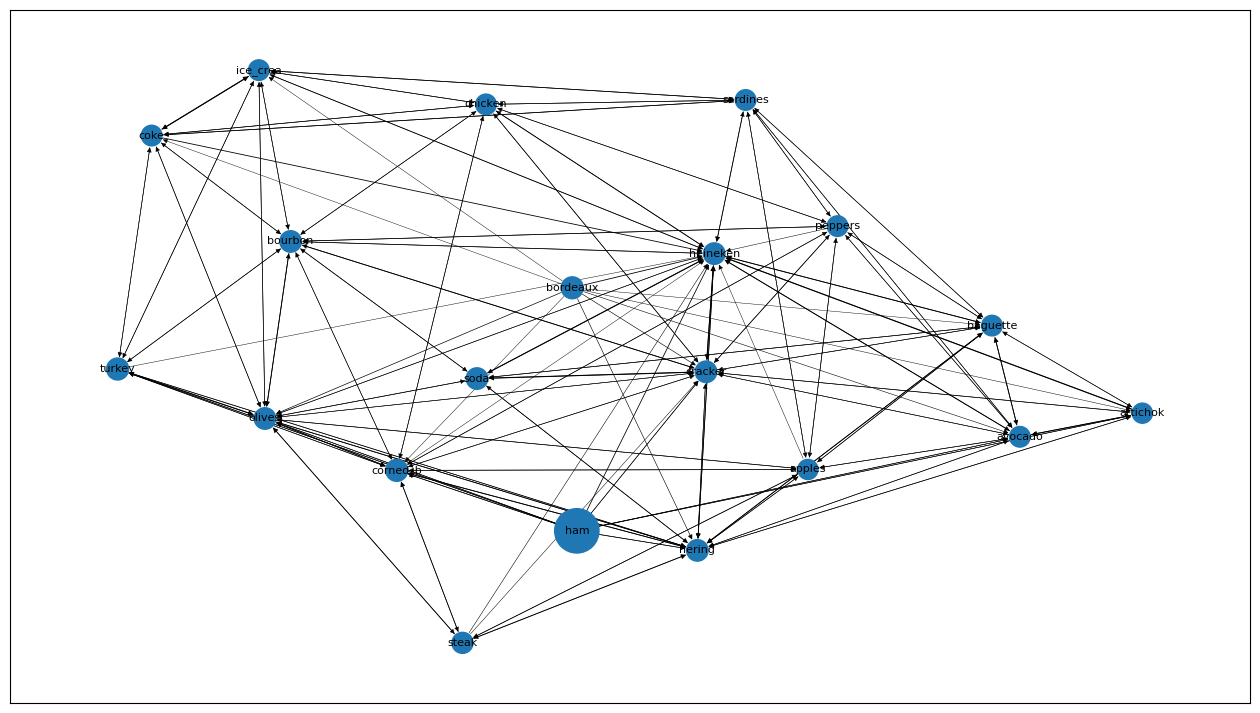

In [11]:
G = nx.DiGraph()
item_support = {item: support for itemset, support in zip(frequent_itemsets['itemsets'], frequent_itemsets['support']) for item in itemset}
for item in item_support:
    G.add_node(item, size=item_support[item] * 10000)
for _, row in filtered_rbc_size2.iterrows():
    A = list(row['antecedents'])[0]
    B = list(row['consequents'])[0]
    confidence = row['confidence']
    G.add_edge(A, B, weight=confidence)
plt.figure(figsize=(16, 9))
pos = nx.spring_layout(G,seed=13)
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
edges = G.edges(data=True)
nx.draw_networkx_nodes(G,pos=pos,node_size=node_sizes)
nx.draw_networkx_edges(G,pos=pos,width=[d['weight'] for (_, _, d) in edges],arrowsize=7)
nx.draw_networkx_labels(G,pos=pos,font_size=8)
plt.show()

#### 6. Для данного графа рассчитайте меры центральности согласно вашему варианту и найдите элемент с самой высокой мерой, а также какую меру имеет продукт из вашего варианта.

Рассчитаем меры центральности для варианта 1 Betweenness

<BarContainer object of 20 artists>

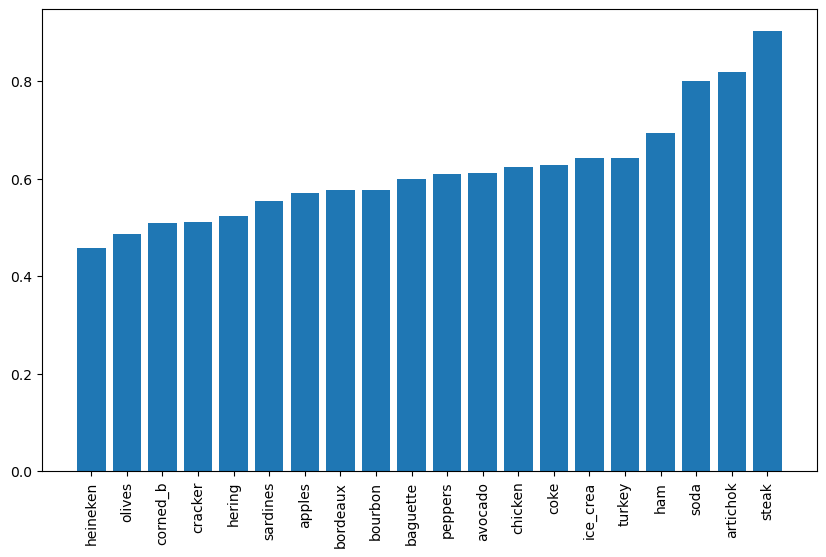

In [12]:
plt.figure(figsize=(10,6))
metr=nx.clustering(G)
metr = dict(sorted(metr.items(), key=lambda x: x[1]))
plt.xticks(rotation = 'vertical')
plt.bar(metr.keys(),metr.values())

Найдем меру bourbon и максимальную меру

In [13]:
metr['bourbon'],list(metr.items())[-1]

(0.5777777777777777, ('steak', 0.9024390243902439))

#### 7. Постройте числовую матрицу со счетчиком числа покупок в ячейках, клиентами по строкам и продуктами по столбцам.

In [14]:
purchase_matrix = data.pivot_table(index='CUSTOMER', columns='PRODUCT', aggfunc='size', fill_value=0)
purchase_matrix

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
CUSTOMER,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
997,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
998,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,1,0,0


# Задание 2 «Выявление скрытых структур в данных»

#### 8. С помощью метода из вашего варианта постройте линейную проекцию набора данных на плоскость (2 компоненты) цветом укажите транзакции, содержащие продукт  вашего варианта.
PCA согласно варианту

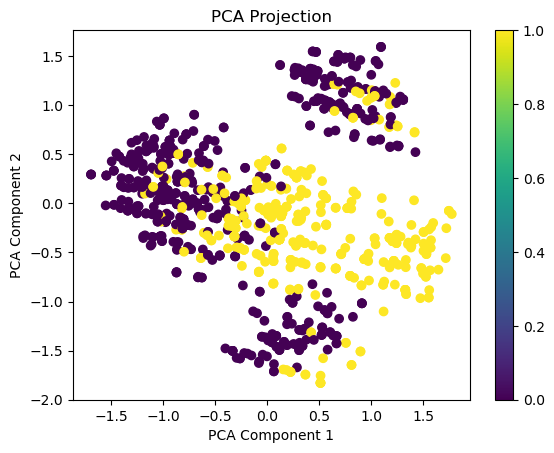

In [71]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(basket)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=basket['bourbon'])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection')
plt.colorbar()
plt.show()

#### 9. С помощью метода из вашего варианта постройте нелинейную проекцию набора данных на плоскость цветом укажите транзакции, содержащие продукт из вашего варианта. Не указанные в задании параметры (например, размер решетки для SOM или число слоев в автоэнкодере можно выбирать на свое усмотрение для получение наиболее удобной визуализации). Дайте письменный комментарий, чем с вашей точки зрения для вашего примера лучше или хуже нелинейная проекция.
Согласно варианту AutoEncoder

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

X = purchase_matrix.values.astype('float32')


In [137]:
input_dim = X.shape[1]

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(10, activation='relu')(input_layer)
encoded = layers.Dense(5, activation='relu')(encoded)
bottleneck = layers.Dense(2, activation='linear')(encoded)  # 2D

decoded = layers.Dense(5, activation='relu')(bottleneck)
decoded = layers.Dense(10, activation='relu')(decoded)
output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
encoder = models.Model(inputs=input_layer, outputs=bottleneck)  # для извлечения 2D

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X, X, epochs=100, batch_size=32, shuffle=True, verbose=1)
X_2d = encoder.predict(X)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6914   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6818 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6504 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6291 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6086 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5939 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5681 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5570 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5420 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5370 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5313 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5304 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5256 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5136 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

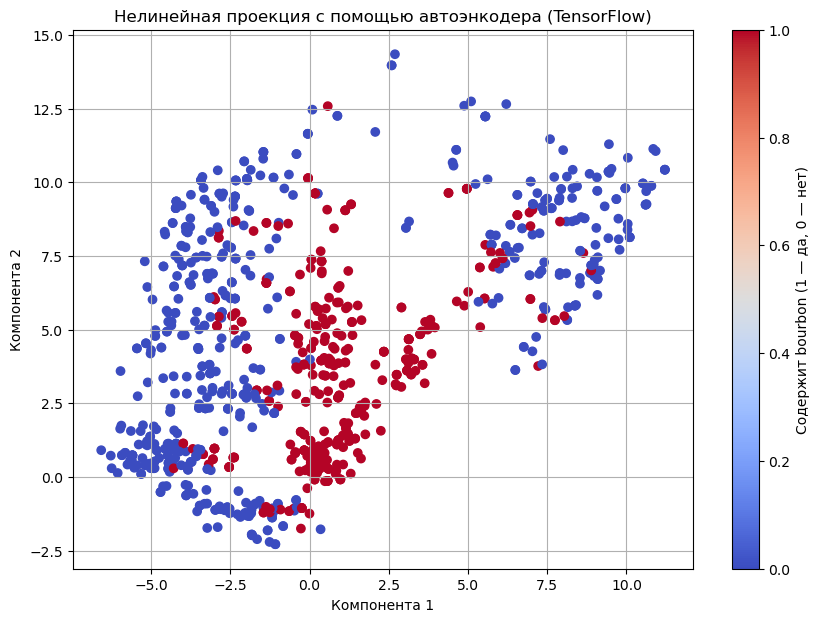

In [138]:

labels = np.where(purchase_matrix['bourbon'] > 0, 1, 0)


plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels,cmap='coolwarm', marker='o')
plt.colorbar(label='Содержит bourbon (1 — да, 0 — нет)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.title('Нелинейная проекция с помощью автоэнкодера (TensorFlow)')
plt.grid(True)
plt.show()


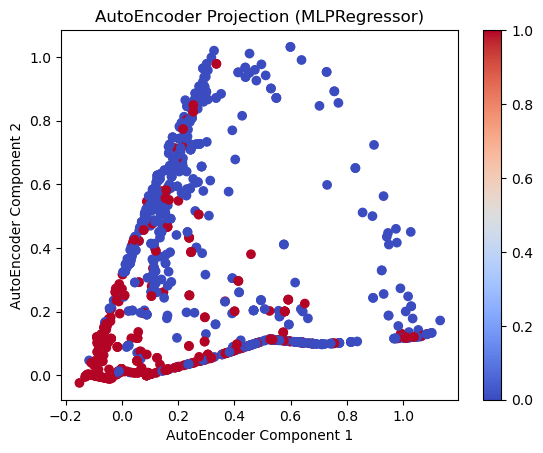

In [136]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(16, 2, 16), activation='relu', max_iter=500, random_state=42)
mlp.fit(purchase_matrix, purchase_matrix) 

encoded_data = mlp.predict(purchase_matrix)[:, :2]

plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels,cmap='coolwarm')
plt.xlabel('AutoEncoder Component 1')
plt.ylabel('AutoEncoder Component 2')
plt.title('AutoEncoder Projection (MLPRegressor)')
plt.colorbar()
plt.show()


PCA – быстрый и простой метод, но работает только с линейными зависимостями. AutoEncoder – сложнее, но ловит нелинейные связи и может лучше выделять скрытые структуры. Если данные простые, PCA хватит. Если есть сложные зависимости, AutoEncoder может дать более четкую группировку.

#### 10.  Из исходной матрицы (из пункта 7) согласно вашему варианту отберите указанное число независимых переменных с использованием заданного метода.

In [ ]:
corr_matrix = cov2corr(np.cov(purchase_matrix.T))

linkage_matrix = linkage(corr_matrix, method='ward')
clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')

selected_features = []
for i in range(1, 5):
    selected_features.append(np.where(clusters == i)[0][0])

print("Выбранные переменные:", selected_features)

Выбранные переменные: [9, 1, 6, 0]
